In [159]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [160]:
import numpy as np
import pandas as pd

In [161]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [162]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [163]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [164]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [165]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [166]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [167]:
# Create our session (link) from Python to the DB
inspector=inspect(engine)
session = Session(engine)

In [168]:
print(inspector.get_table_names())
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

['measurement', 'station']
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [169]:
print(inspector.get_table_names())
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

['measurement', 'station']
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

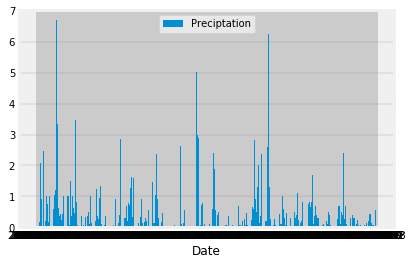

In [34]:
# Calculate the date 1 year ago from the last data point in the database
query = session.query(Measurement.date,Measurement.prcp).order_by(Measurement.date.desc()).first()
ql=query[0]
hurr=dt.datetime.strptime(ql, '%Y-%m-%d')
# When I used 365 days the dataframe description in the next cell was slightly different from the expected result posted on Gitlab.
# On further inspection I discovered 2016 was a leap year! Thus, the results you posted on Gitlab actually used 366 days, instead of 365. 
date12mosago=hurr-dt.timedelta(days=366) 
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= date12mosago)
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(query,columns=('date','prcp'))
df=df.set_index('date')
# Sort the dataframe by date
df=df.sort_values(by=["date"])
# Use Pandas Plotting with Matplotlib to plot the data
x_axis=df.index
y_axis=df["prcp"]
plt.bar(x_axis,y_axis, label='Preciptation')
plt.xlabel('Date')
plt.legend(loc= 'upper center')
plt.grid(axis='y',color='grey',linestyle='-',linewidth=0.25)
plt.show()

![precipitation](Images/precipitation.png)

In [35]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [44]:
# Design a query to show how many stations are available in this dataset?
query2=session.query(Station.station).count()
print(query2)

9


In [65]:
# What are the most active stations? (i.e. what stations have the most rows)?
query3=session.query(Station.station, func.count(Measurement.station)). \
filter(Station.station == Measurement.station). \
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

query3

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [81]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
query_lowest_temp=session.query(Measurement.station, Measurement.tobs). \
filter(Measurement.station == 'USC00519281').\
order_by(Measurement.tobs.asc()).first()
lowest_temp=query_lowest_temp[1]

query_highest_temp=session.query(Measurement.station, Measurement.tobs). \
filter(Measurement.station == 'USC00519281').\
order_by(Measurement.tobs.desc()).first()
highest_temp=query_highest_temp[1]

query_average=session.query(Measurement.station, func.avg(Measurement.tobs)). \
filter(Measurement.station == 'USC00519281').all()
average_temp=query_average[0][1]

tupleform=[(lowest_temp,highest_temp,average_temp)]
tupleform


[(54.0, 85.0, 71.66378066378067)]

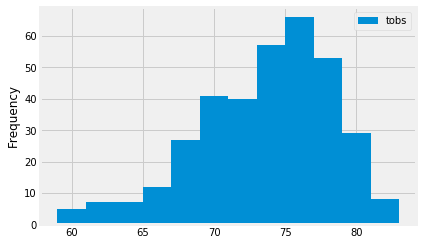

In [91]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query4=session.query(Measurement.station, Measurement.tobs). \
filter(Measurement.station == 'USC00519281').filter(Measurement.date >= date12mosago).all()
df2 = pd.DataFrame(query4,columns=('Station','Temperature'))
x=list(df2["Temperature"])
plt.hist(x,bins=12, label='tobs')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


![precipitation](Images/station-histogram.png)

In [95]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [98]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tripstart='2017-07-07'
tripend='2017-07-11'
func_run=calc_temps(tripstart, tripend)
tave=func_run[0][1]
tmin=func_run[0][0]
tmax=func_run[0][2]
func_run


[(69.0, 77.66666666666667, 82.0)]

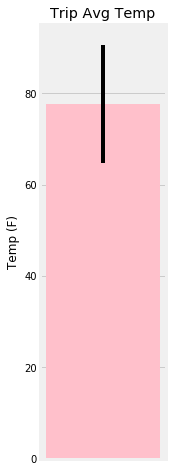

In [108]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
errr=tmax-tmin
fig,ax=plt.subplots()
ax.bar([0],tave,yerr=errr,color='pink',width=0.3)
ax.set_ylabel('Temp (F)')
ax.set_title('Trip Avg Temp')
ax.set_xticks([])
fig.set_figheight(8)
fig.set_figwidth(2)
plt.show()


## Optional Challenge Assignment

In [123]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
tripinfo=session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, \
                       Station.latitude, Station.longitude, Station.elevation).filter(Measurement.station==Station.station). \
                        filter(Measurement.date >= tripstart).filter(Measurement.date <= tripend).group_by(Measurement.station).\
                        order_by(func.sum(Measurement.prcp)).all()
tripinfo


[('USC00517948', None, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00519397', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519523',
  0.0,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  0.06,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00513117', 0.14, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00519281',
  0.33,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00516128',
  0.34,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4)]

In [124]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [149]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]
dates=[]
dates_with_years=[]
# Use the start and end date to create a range of dates

date1 = '2017-07-07'
date2 = '2017-07-11'
start = dt.datetime.strptime(date1, '%Y-%m-%d')
end = dt.datetime.strptime(date2, '%Y-%m-%d')
step = dt.timedelta(days=1)
# Stip off the year and save a list of %m-%d strings
while start <= end:
    date_year=str(start.date())
    date_noyear=date_year.replace('2017-', '')
    dates.append(date_noyear)
    dates_with_years.append(date_year)
    start += step
dates
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in dates:
    normals.append(daily_normals(date)[0])
normals

[(69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0),
 (68.0, 76.19298245614036, 83.0),
 (68.0, 75.62068965517241, 82.0),
 (70.0, 75.78947368421052, 81.0)]

In [153]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df3 = pd.DataFrame(normals,columns=('tmin','tavg','tmax'))
df3["dates"]=dates_with_years
df3=df3.set_index(['dates'])
df3

,tmin,tavg,tmax
dates,,,
2017-07-07,69.0,74.910714,82.0
2017-07-08,69.0,76.083333,83.0
2017-07-09,68.0,76.192982,83.0
2017-07-10,68.0,75.620690,82.0
2017-07-11,70.0,75.789474,81.0


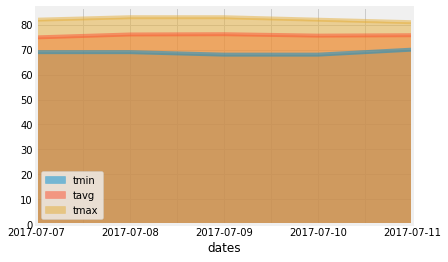

In [158]:
# Plot the daily normals as an area plot with `stacked=False`
df3.plot.area(stacked=False)